In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [57]:
# import data
data = pd.read_csv('Données_marché_Lait.csv')
print('Dataset length:', len(data))
data.head()

Dataset length: 10898


,Date,Composants de coûts,Devise,Type de données,Source de données,Commerce extérieur,Indicateur,Marché,Produit,Groupe de produits,Système de production,Provenance du produit,Propriétés du produit,Sous-groupe de produits,Région de vente,Unité,Mode d’utilisation,Echelon de création de valeur_Détail,Echelon de création de valeur,Prix
0,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait de centrale (conventionnel),Lait cru,Conventionnel,Région 2,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,70.590753
1,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait de prairie IP Suisse,Lait cru,IP Suisse,Suisse,NaN,Lait cru CH,Suisse,kg,Lait cru sans définition supplémentaire,Au départ de la ferme (échelon de la production),Production,76.338026
2,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,Lait transformé en fromage (conventionnel),Lait cru,Conventionnel,Suisse,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,77.631932
3,01-2024,TVA incluse,Centimes,Valeur réalisée,"OFAG, secteur Analyses du marché",NaN,Prix,Lait et produits laitiers,"Lait CH, total",Lait cru,NaN,Région 5,NaN,Lait cru CH,Suisse,kg,NaN,Au départ de la ferme (échelon de la production),Production,77.900726
4,01-2024,NaN,Centimes,Prix indicatif,IPL,NaN,Prix,Lait et produits laitiers,"Lait conventionnel, total",Lait cru,Conventionnel,Suisse,NaN,Lait cru CH,Suisse,kg,segment A,Production non définie,Production,79.000000


In [58]:
# Check number of unique values in each column
data.nunique()

Date                                      277
Composants de coûts                         2
Devise                                      1
Type de données                             2
Source de données                           8
Commerce extérieur                          0
Indicateur                                  1
Marché                                      1
Produit                                    20
Groupe de produits                          1
Système de production                       3
Provenance du produit                      14
Propriétés du produit                       0
Sous-groupe de produits                     2
Région de vente                             8
Unité                                       1
Mode d’utilisation                          3
Echelon de création de valeur_Détail        2
Echelon de création de valeur               1
Prix                                    10334
dtype: int64

In [59]:
# At this point you can remove column with unique values which are not useful and does not 
# provide information for the analysis for example Devise and Groupe de produit
# ATENTION il faut bien retenir que la devise est en centimes pour l'analyse
clean_data = data.copy()
# drop columns
clean_data = clean_data.drop(['Devise', 'Groupe de produits', 'Commerce extérieur', 'Indicateur',\
                   'Marché', 'Propriétés du produit', 'Unité', 'Echelon de création de valeur '], axis=1)

clean_data.head()

,Date,Composants de coûts,Type de données,Source de données,Produit,Système de production,Provenance du produit,Sous-groupe de produits,Région de vente,Mode d’utilisation,Echelon de création de valeur_Détail,Prix
0,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait de centrale (conventionnel),Conventionnel,Région 2,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),70.590753
1,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait de prairie IP Suisse,IP Suisse,Suisse,Lait cru CH,Suisse,Lait cru sans définition supplémentaire,Au départ de la ferme (échelon de la production),76.338026
2,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché",Lait transformé en fromage (conventionnel),Conventionnel,Suisse,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),77.631932
3,01-2024,TVA incluse,Valeur réalisée,"OFAG, secteur Analyses du marché","Lait CH, total",NaN,Région 5,Lait cru CH,Suisse,NaN,Au départ de la ferme (échelon de la production),77.900726
4,01-2024,NaN,Prix indicatif,IPL,"Lait conventionnel, total",Conventionnel,Suisse,Lait cru CH,Suisse,segment A,Production non définie,79.000000


On va mtn regarder les Nan, on va les remplacer ou juste les drop selon l'info qu'on tire :

In [60]:
# show unique values in each column
columns = ['Composants de coûts', 'Type de données', 'Source de données', 'Système de production',\
            'Provenance du produit', 'Sous-groupe de produits', 'Région de vente', 'Mode d’utilisation', 'Echelon de création de valeur_Détail']
for col in columns:
    print(col, clean_data[col].unique(), '\n')


Composants de coûts ['TVA incluse' nan 'Hors TVA'] 

Type de données ['Valeur réalisée' 'Prix indicatif'] 

Source de données ['OFAG, secteur Analyses du marché' 'IPL' 'CLAL Italien' 'IFE'
 'France Agrimer' 'AMA Österreich' 'BLE Deutschland'
 'Commission européenne'] 

Système de production ['Conventionnel' 'IP Suisse' nan 'Bio'] 

Provenance du produit ['Région 2' 'Suisse' 'Région 5' 'Région 1' 'Italie'
 'Reste du monde, non suisse' 'Région 4' 'Région 3' 'France'
 'Nouvelle-Zélande' 'USA / Canada' 'Autriche' 'Allemagne' 'UE'] 

Sous-groupe de produits ['Lait cru CH' 'Lait cru, International'] 

Région de vente ['Suisse' 'Italie' nan 'France' 'Nouvelle-Zélande' 'USA' 'Autriche'
 'Allemagne' 'UE-28'] 

Mode d’utilisation [nan 'Lait cru sans définition supplémentaire' 'segment A' 'segment B'] 

Echelon de création de valeur_Détail ['Au départ de la ferme (échelon de la production)'
 'Production non définie'] 



On drop toutes les régions non suisses de la colonne "provenance du produit".

In [61]:
# créer une nouvelle variable incluant toutes les régions suisses
suisse_region = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5'] 
# Après c'est bien de revenir la dessus et de faire une analyse après avec le reste des pays pour comparer la suisse avec les autres pays

# filter data to keep only switzerland production
swiss_production_data = clean_data[clean_data['Provenance du produit'].isin(suisse_region)]

In [9]:
# is there any nan in prix column
swiss_production_data['Prix'].isna().sum()
# Replace nan in the whole dataset with 'unknown'
swiss_production_data = swiss_production_data.fillna('unknown')

# Convert date from string to datetime
swiss_production_data['Date'] = pd.to_datetime(swiss_production_data['Date'])

print(swiss_production_data['Région de vente'].unique())
# Le fait que Region de vente n'ait plus qu'une valeur unique signifie que tout le lait produit en suisse est vendu en suisse
# C'est une colonne avec plus qu'une seule info donc on peut potentiellement la supprimer, c'est pour ca que c'est en blanc dans le correlation plot
# IDEM pour sous groupe de produits
len(swiss_production_data)

# Sauvegarder le nouvel ensemble de données dans un nouveau fichier CSV
swiss_production_data.to_csv('Swiss_Production.csv', index=False)

['Suisse']


/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_1428/3713976618.py:7: UserWarning:
/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_33031/1362209068.py:12: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



5817

(je voulais quand même montrer la différence de production (kg de lait) entre toutes les régions suisses confondues et les régions externe à la Suisse, histoire de comparer le pourcentage de lait produit à l'étranger par rapport au lait produit en Suisse).

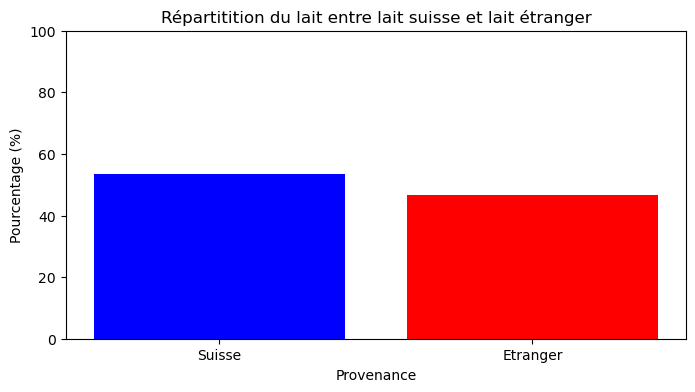

Provenance
Suisse      53.376766
Etranger    46.623234
Name: proportion, dtype: float64


In [10]:
# créer une nouvelle variable incluant toutes les régions suisses
swiss_production_data = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5'] 

# Créer une nouvelle colonne pour la classification
clean_data['Provenance'] = clean_data['Provenance du produit'].apply(lambda x: 'Suisse' if x in swiss_production_data else 'Etranger')

# Calculer les pourcentages
category_counts = clean_data['Provenance'].value_counts(normalize=True) * 100

# Créer un diagramme à barres pour visualiser les pourcentages
plt.figure(figsize=(8, 4))
plt.bar(category_counts.index, category_counts.values, color=['blue', 'red'])
plt.xlabel('Provenance')
plt.ylabel('Pourcentage (%)')
plt.title('Répartitition du lait entre lait suisse et lait étranger')
plt.ylim(0, 100)  # Fixer les limites de l'axe y pour le pourcentage
plt.show()

print(category_counts)

Nous pouvons remarquer qu'il y a plus de lait venant de Suisse que venant d'importations. 

Faire graphe avec les différences de prix entre lait suisse et lait étranger. 

In [11]:
# Can't deal with string for statistical analysis, so we need to convert them to numerical values
# Label encoding

# # Initialize a label encoder for each string column
# label_encoders = {}

# for column in swiss_production_data.columns:
#     if swiss_production_data[column].dtype == 'object':  # if the column has string values
#         le = LabelEncoder()
#         swiss_production_data[column] = le.fit_transform(swiss_production_data[column])
#         label_encoders[column] = le  # store the label encoder for future reference

# # Now df is encoded and you have a dictionary of label encoders for each string column
# print(swiss_production_data.head())

UNIVARIATE ANALYSIS 

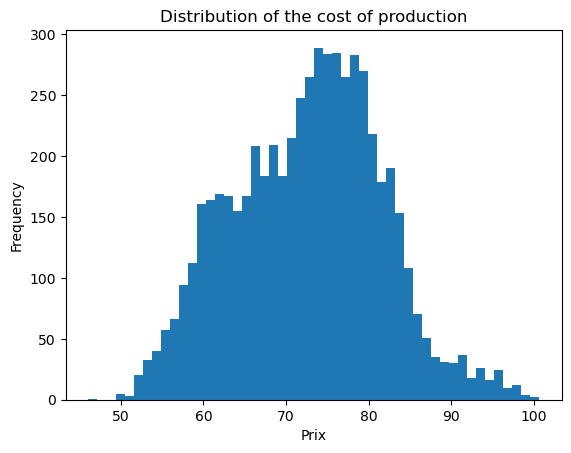

In [12]:
swiss_histogram = pd.read_csv('Swiss_Production.csv')

# plot distribution of the cost of production, all regions combined.
plt.hist(swiss_histogram['Prix'], bins=50, density=True, alpha=0.5)
plt.xlabel('Prix')
plt.ylabel('Frequency')
plt.title('Distribution of the cost of production')
plt.show()

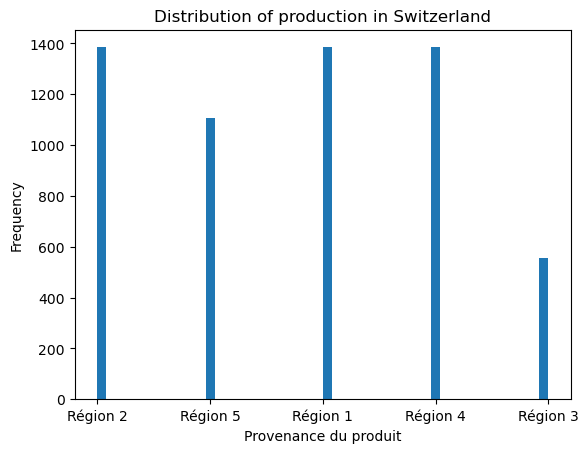

In [65]:
# plot distribution of the repartition of production in Switzerland
plt.hist(swiss_production_data['Provenance du produit'], bins=50)
plt.xlabel('Provenance du produit')
plt.ylabel('Frequency')
plt.title('Distribution of production in Switzerland')
plt.show()

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



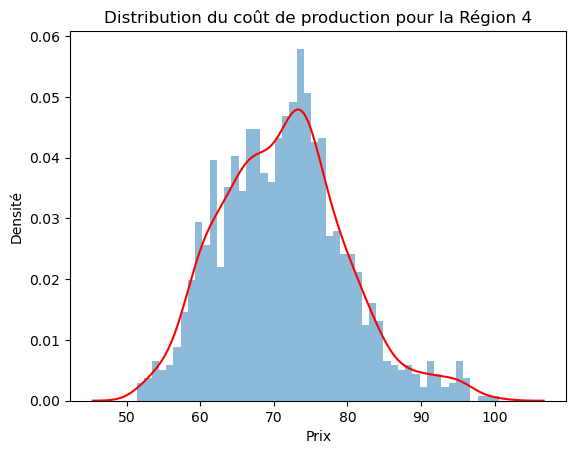

In [ ]:
region_specific_data = swiss_production_data[swiss_production_data['Provenance du produit'] == 'Région 4']

# Calculez l'histogramme et obtenez les valeurs de bin (intervalles) et les fréquences
counts, bin_edges = np.histogram(region_specific_data['Prix'], bins=50, density=True)

# Calculez les points centraux des bins pour tracer la courbe KDE 'Kernel Density Estimate'
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Tracez l'histogramme
plt.hist(region_specific_data['Prix'], bins=50, density=True, alpha=0.5)

# Utilisez seaborn pour ajouter la courbe KDE
sns.kdeplot(region_specific_data['Prix'], color='red')


plt.xlabel('Prix')
plt.ylabel('Densité')
plt.title('Distribution du coût de production pour la Région 4')
plt.show()

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



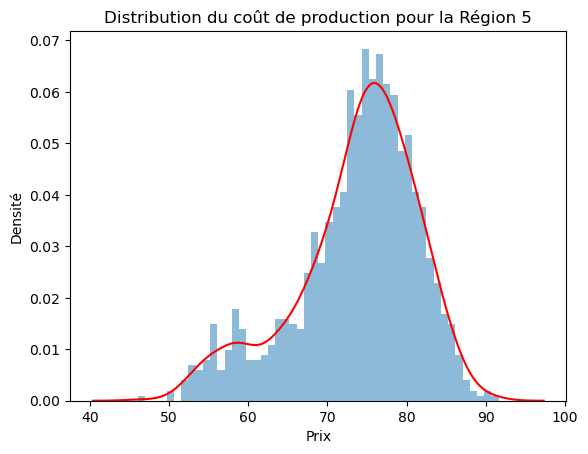

In [ ]:
region_specific_data = swiss_production_data[swiss_production_data['Provenance du produit'] == 'Région 5']

# Calculez l'histogramme et obtenez les valeurs de bin (intervalles) et les fréquences
counts, bin_edges = np.histogram(region_specific_data['Prix'], bins=50, density=True)

# Calculez les points centraux des bins pour tracer la courbe KDE 'Kernel Density Estimate'
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Tracez l'histogramme
plt.hist(region_specific_data['Prix'], bins=50, density=True, alpha=0.5)

# Utilisez seaborn pour ajouter la courbe KDE
sns.kdeplot(region_specific_data['Prix'], color='red')


plt.xlabel('Prix')
plt.ylabel('Densité')
plt.title('Distribution du coût de production pour la Région 5')
plt.show()

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raimon/miniconda3/envs/test-project/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/raimon/miniconda3/env

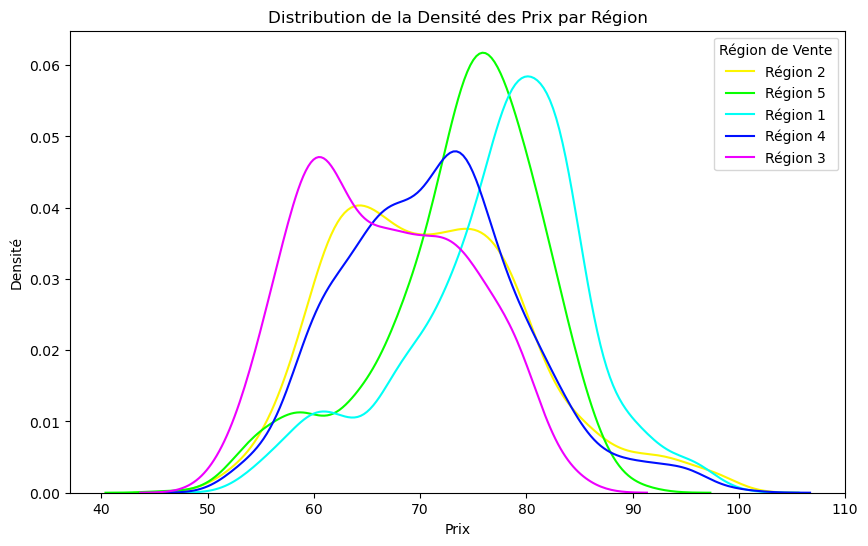

In [ ]:
# Ensemble de couleurs pour différencier chaque région
palette = sns.color_palette("hsv", 5)  # Génère 5 couleurs distinctes

# Création du graphique
plt.figure(figsize=(10, 6))  # Ajustez la taille selon vos besoins

# Boucle sur chaque région unique dans le DataFrame
for i, region in enumerate(swiss_production_data['Provenance du produit'].unique()):
    # Filtrer les données pour chaque région
    subset = swiss_production_data[swiss_production_data['Provenance du produit'] == region]
    # Tracer la distribution des prix pour chaque région
    sns.kdeplot(subset['Prix'], label=region, color=palette[i])

# Ajouter des légendes et titres
plt.title('Distribution de la Densité des Prix par Région')
plt.xlabel('Prix')
plt.ylabel('Densité')
plt.legend(title='Région de Vente')

# Afficher le graphique
plt.show()


Les régions 5 et 1 montrent un prix plus élevé comparé aux autres régions. La région 3 présente le prix le plus bas dans toute la Suisse.

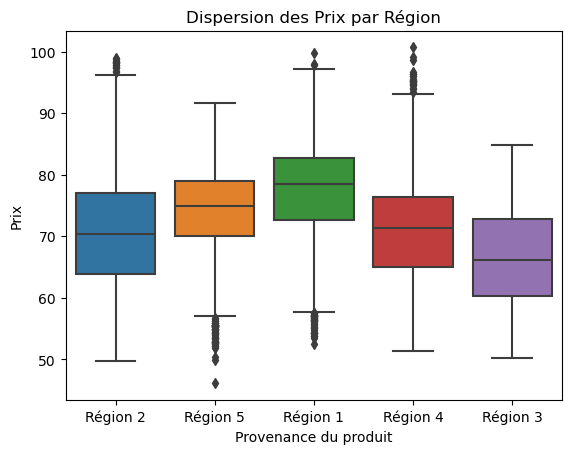

In [ ]:
# plot la dispersion des prix pour chaque région, pour potentiellement permettre d'expliquer cet écart de densité.
sns.boxplot(x='Provenance du produit', y='Prix', data=swiss_production_data)
plt.title('Dispersion des Prix par Région')
plt.show()


Stabilité des prix : Les régions 1 et 3 montrent une plus grande stabilité des prix avec des boîtes plus courtes, indiquant moins de dispersion.

Volatilité des prix : Les régions 5 et 4 présentent une plus grande volatilité des prix comme indiqué par des étendues de prix plus larges et la présence d'outliers.

Distribution de la production de lait pour chaque région suisse.

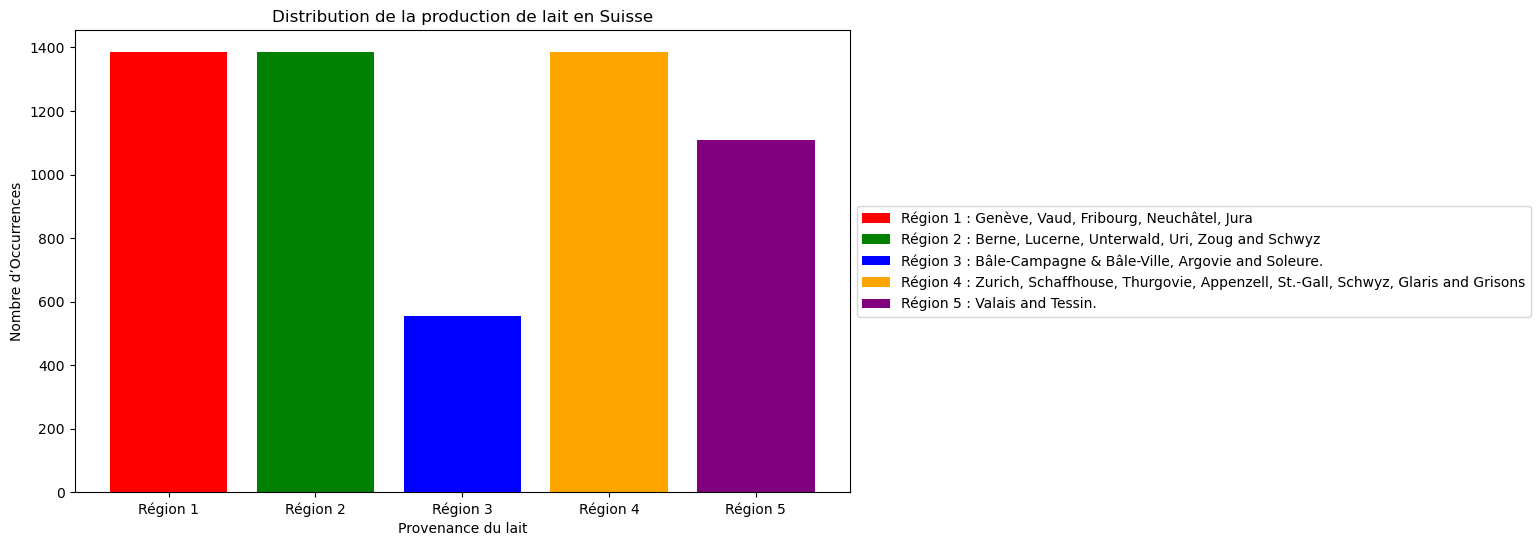

Provenance du produit
Région 1    1385
Région 2    1385
Région 3     554
Région 4    1385
Région 5    1108
Name: count, dtype: int64


In [ ]:
# Compter les occurrences de chaque type de produit
product_counts = swiss_production_data['Provenance du produit'].value_counts()

# Définir l'ordre souhaité des régions
order = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5']

# Réindexer les données selon l'ordre souhaité
product_counts = product_counts.reindex(order)

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(product_counts.index, product_counts.values, color=['red', 'green', 'blue', 'orange', 'purple'])

# Descriptions détaillées pour chaque type de produit
labels = ['Région 1 : Genève, Vaud, Fribourg, Neuchâtel, Jura', 
          'Région 2 : Berne, Lucerne, Unterwald, Uri, Zoug and Schwyz', 
          'Région 3 : Bâle-Campagne & Bâle-Ville, Argovie and Soleure.',
          'Région 4 : Zurich, Schaffhouse, Thurgovie, Appenzell, St.-Gall, Schwyz, Glaris and Grisons',
          'Région 5 : Valais and Tessin.']

# Assigner une étiquette à chaque barre pour la légende
for bar, label in zip(bars, labels):
    bar.set_label(label)

# Ajouter la légende
# Ajouter la légende sur le côté gauche
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Ajouter des titres et des étiquettes aux axes
plt.title('Distribution de la production de lait en Suisse')
plt.xlabel('Provenance du lait')
plt.ylabel('Nombre d’Occurrences')

# Afficher le graphique
plt.show()

# Afficher les valeurs exactes de chaque région 
print(product_counts)


Nous pouvons remarquer que les régions 1, 2 et 4 produisent une plus grande quantité de lait par rapport aux régions 3 et 5. 

!!! revoir les labels de chaque région 

MULTIVARIATE VISUALIZATIONS 

Evolution du prix moyen du lait à l'échelle nationale 

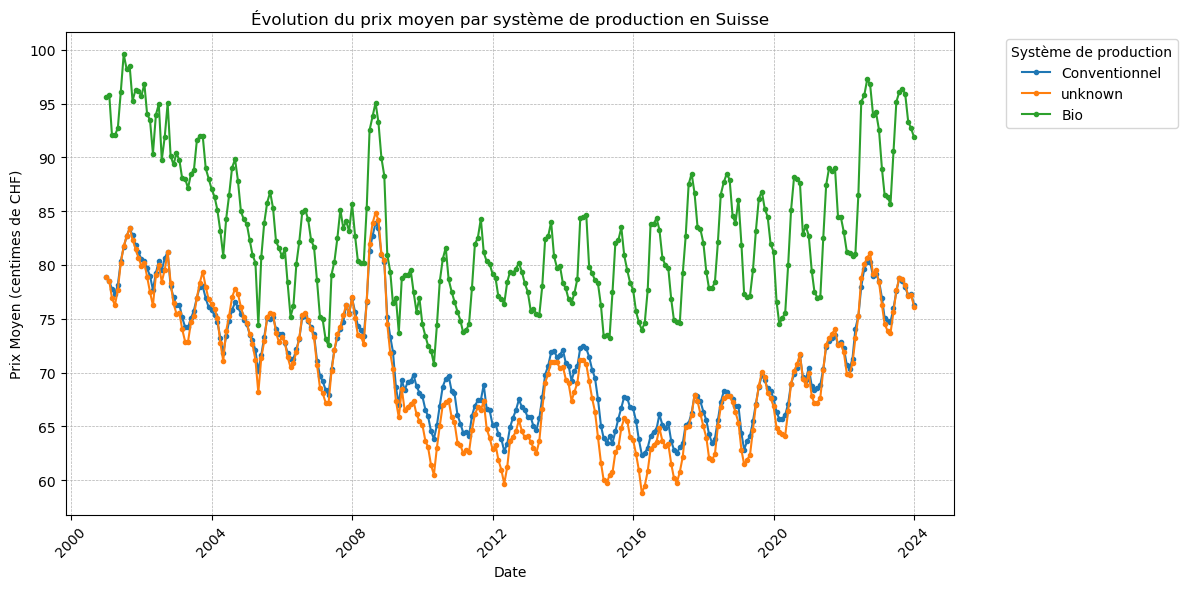

In [ ]:
# plot "l'évolution du prix moyen de production en fonction du système de production"
# Calculer la moyenne des prix pour chaque date et chaque système de production
swiss_production_data_moyenne = swiss_production_data.groupby(['Date', 'Système de production'])['Prix'].mean().reset_index()

# Sélectionner les systèmes de production uniques
systemes_production = swiss_production_data['Système de production'].unique()

# Créer un graphique pour chaque système de production
plt.figure(figsize=(12, 6))  # Ajuste la taille du graphique selon tes besoins

for systeme in systemes_production:

    # Filtrer le DataFrame pour chaque système de production
    swiss_production_data_filtre = swiss_production_data_moyenne[swiss_production_data_moyenne['Système de production'] == systeme]
 
    # Tracer la courbe pour le système de production filtré
    plt.plot(swiss_production_data_filtre['Date'], swiss_production_data_filtre['Prix'],marker='.', linestyle='-', label=systeme)

# Ajout des légendes, titres et étiquettes
plt.title('Évolution du prix moyen par système de production en Suisse')
plt.xlabel('Date')
plt.ylabel('Prix Moyen (centimes de CHF)')
plt.legend(title='Système de production', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajoute une légende pour distinguer les systèmes et déplace la à l'extérieur
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)  # Rotation des étiquettes pour les rendre lisibles

plt.tight_layout()  # Ajuste la disposition
plt.show()  # Affiche le graphique

Nous pouvons observer que le prix moyen par kg de lait produit est évelé au début des années 2001, environ 80 centimes pour la production de lait conventionnel et plus de 95 centimes pour le lait bio. 

De plus, les données 'unknown' sont fortement corrélées avec les données 'conventionnel'. 

Nous remarquons une saisonalité au niveau des données, avec une trend non linéaire : trend descendante entre 2001 et 2016 et trend ascendante entre 2016 et 2024.

Puis il y a une diminution des prix, bio et conventionnel, jusqu'en 2007 suivi d'un pic en 2008 (potentiel corrélation avec la crise de 2008?) et d'un deuxième en 2014 pour le lait conventionnel. 

A partir de 2020, les prix recommencent à grimper, puis restent plutôt constant sur ces deux dernières années.

Faire forecasting du graphe au-dessus pour bio et conventionnel avec R (et sur 2 ans environ)

Décomposition additive de la production suisse 

/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_31664/3669609776.py:13: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



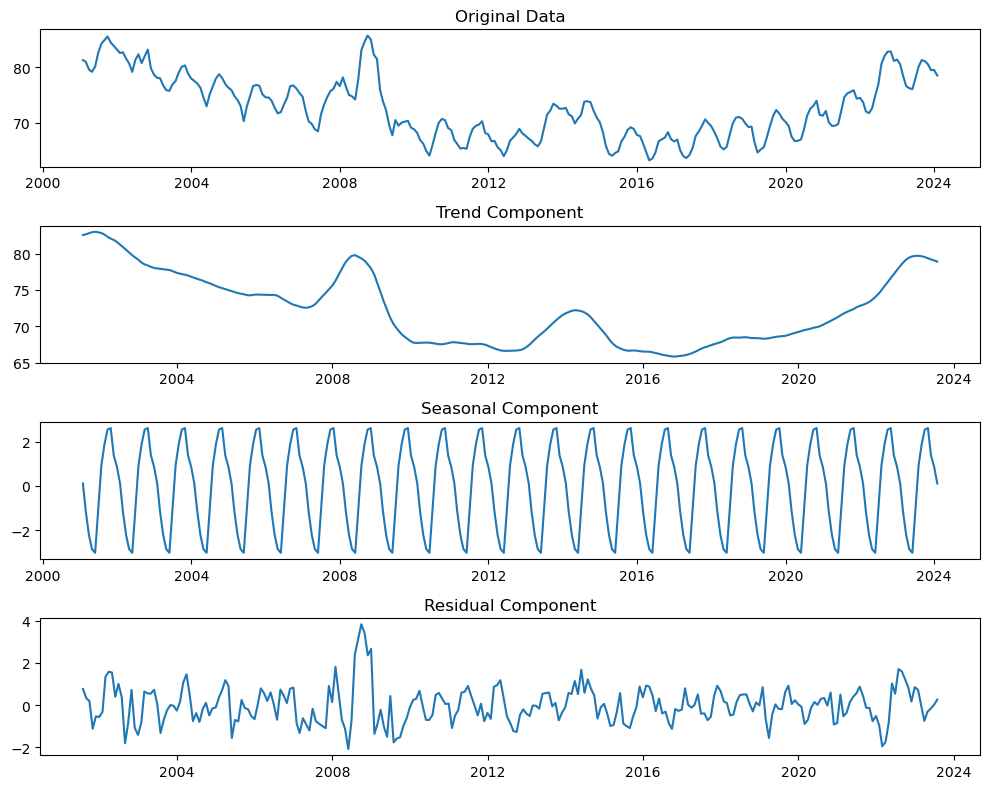

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# import data
swiss_decomposition = pd.read_csv('Swiss_Production.csv')

# Assurez-vous que les dates sont de type datetime et que 'Date' est l'index
swiss_decomposition['Date'] = pd.to_datetime(swiss_decomposition['Date'])
swiss_decomposition.set_index('Date', inplace=True)

# Calculez la moyenne des prix par date
data = swiss_decomposition['Prix'].resample('M').mean()

# Appliquez la décomposition classique
decomposition = sm.tsa.seasonal_decompose(data, model='additive')  # ou 'multiplicative' selon le cas

# Créez un graphique avec des subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# Plot the original data
axes[0].plot(data, label='Original')
axes[0].set_title('Original Data')

# Plot the trend component
axes[1].plot(decomposition.trend, label='Trend')
axes[1].set_title('Trend Component')

# Plot the seasonal component
axes[2].plot(decomposition.seasonal, label='Seasonal')
axes[2].set_title('Seasonal Component')

# Plot the residual component
axes[3].plot(decomposition.resid, label='Residual')
axes[3].set_title('Residual Component')

# Set tight layout and show the plot
plt.tight_layout()
plt.show()


No clear trend - decreases and then increases, with two peaks in 2008 and 2014.

Clear seasonal component - due to weather conditions or agricultural cycles.

Residual component - relatively stable, but shows some peaks, which could indicate anomalies or events not taken into account by the trend and seasonality model.

Nous allons ensuite procéder à un modèle ARIMA saisonniers. Avant d'appliquer ce modèle, il faut vérifier la stationnarité des données (et particulièrement des résidus).

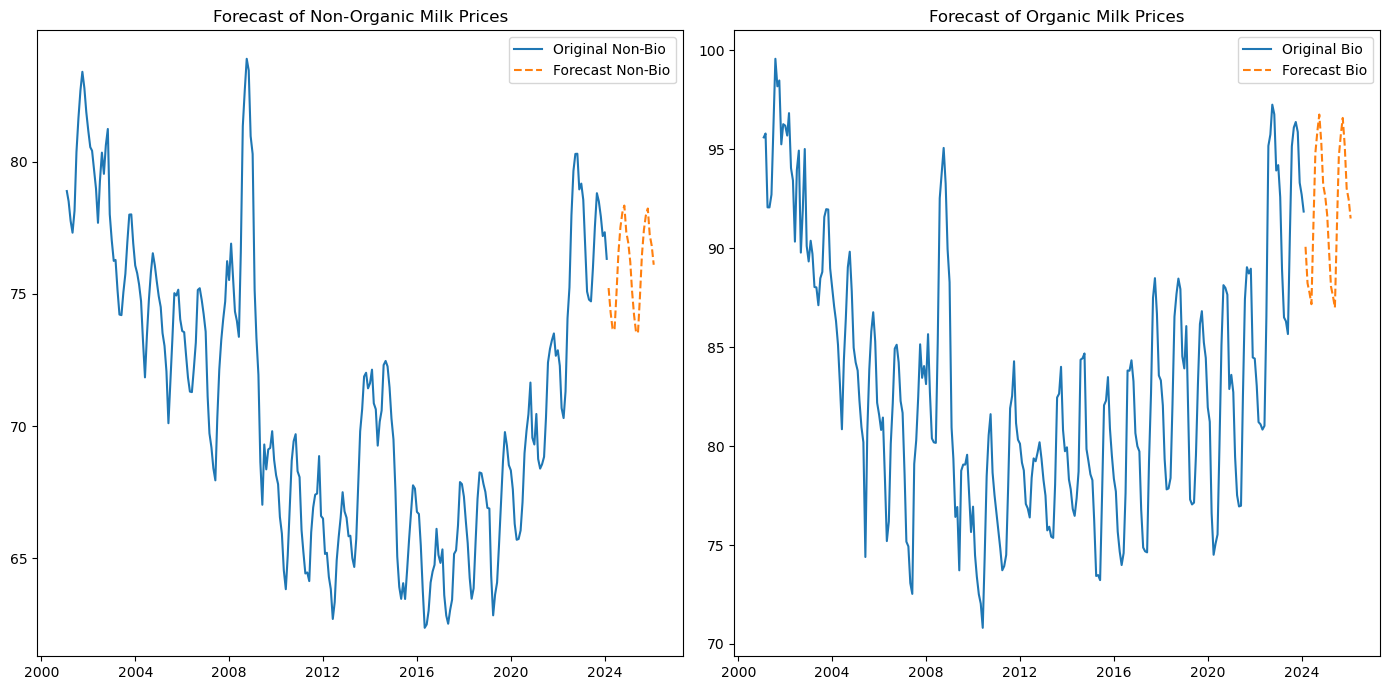

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Charger les données
data = pd.read_csv('Swiss_Production.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filtrer les données pour le lait bio et non bio
data_bio = data[data['Système de production'] == 'Bio']['Prix'].resample('ME').mean()
data_non_bio = data[data['Système de production'] == 'Conventionnel']['Prix'].resample('ME').mean()

# Ajustement des modèles ETS
model_bio = ExponentialSmoothing(data_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_bio = model_bio.fit()

model_non_bio = ExponentialSmoothing(data_non_bio, trend='add', seasonal='add', seasonal_periods=12)
fit_non_bio = model_non_bio.fit()

# Prévision pour les 24 prochains mois
forecast_bio = fit_bio.forecast(24)
forecast_non_bio = fit_non_bio.forecast(24)

# Tracer les résultats
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(data_non_bio, label='Original Non-Bio')
plt.plot(forecast_non_bio, label='Forecast Non-Bio', linestyle='--')
plt.title('Forecast of Non-Organic Milk Prices')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data_bio, label='Original Bio')
plt.plot(forecast_bio, label='Forecast Bio', linestyle='--')
plt.title('Forecast of Organic Milk Prices')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Vérifiez et triez les données par année si nécessaire.
swiss_production_data = pd.read_csv('Swiss_Production.csv')
swiss_production_data['Date'] = pd.to_datetime(swiss_production_data['Date']).dt.year
swiss_production_data = swiss_production_data[swiss_production_data['Date'].between(2001, 2024)]
swiss_production_data.sort_values('Date', inplace=True)

# Créez le graphique avec Plotly Express.
fig = px.bar(
    swiss_production_data, 
    x='Provenance du produit', 
    y='Prix', 
    color='Système de production', 
    barmode='group',
    animation_frame='Date'  
)

# Mise à jour des titres.
fig.update_layout(
    title_text='Prix moyen de la production de lait, en fonction de la région et du système de production',
    xaxis_title='Provenance du Lait',
    yaxis_title='Prix moyen',
)

# Ajouter des détails de hover.
fig.update_traces(
    hovertemplate='Provenance du produit: %{x}<br>Système de production: %{marker.color}<br>Date: %{animation_frame}<br>Prix: %{y}'
)

# Créez des étapes pour le slider.
years = swiss_production_data['Date'].unique()
steps = []
for year in years:
    step = dict(
        method='animate',
        label=str(year),
        args=[[str(year)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}]
    )
    steps.append(step)

# Ajoutez le slider à la figure.
fig.update_layout(
    sliders=[{'steps': steps}]
)

# Supprimez le bouton de lecture automatique.
fig.layout.updatemenus[0].buttons = []

# Affichez le graphique.
fig.show()



MULTIVARIATE ANALYSIS 

Evolution du prix moyen du lait à l'échelle nationale suisse

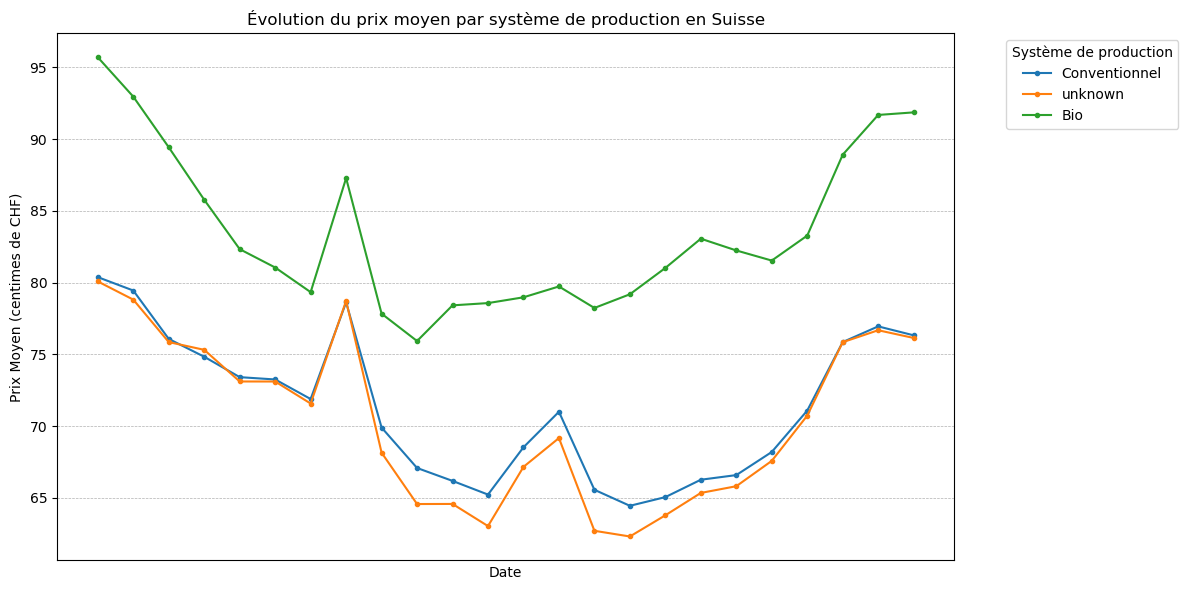

In [70]:
# plot "l'évolution du prix moyen de production en fonction du système de production"
# Calculer la moyenne des prix pour chaque date et chaque système de production
swiss_production_data_moyenne = swiss_production_data.groupby(['Date', 'Système de production'])['Prix'].mean().reset_index()

# Sélectionner les systèmes de production uniques
systemes_production = swiss_production_data['Système de production'].unique()

# Créer un graphique pour chaque système de production
plt.figure(figsize=(12, 6))  # Ajuste la taille du graphique selon tes besoins

for systeme in systemes_production:

    # Filtrer le DataFrame pour chaque système de production
    swiss_production_data_filtre = swiss_production_data_moyenne[swiss_production_data_moyenne['Système de production'] == systeme]
 
    # Tracer la courbe pour le système de production filtré
    plt.plot(swiss_production_data_filtre['Date'], swiss_production_data_filtre['Prix'],marker='.', linestyle='-', label=systeme)

# Ajout des légendes, titres et étiquettes
plt.title('Évolution du prix moyen par système de production en Suisse')
plt.xlabel('Date')
plt.ylabel('Prix Moyen (centimes de CHF)')
plt.legend(title='Système de production', bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajoute une légende pour distinguer les systèmes et déplace la à l'extérieur
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Utilisation des locators et formatters pour l'axe des x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Afficher seulement l'année

plt.xticks(rotation=45)  # Rotation des étiquettes pour les rendre lisibles

plt.tight_layout()  # Ajuste la disposition
plt.show()  # Affiche le graphique




Evolution du prix moyen du lait à l'échelle internationale 

/var/folders/f4/kx7jr27n4zn4nl2q5701x0g40000gn/T/ipykernel_1428/516812024.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



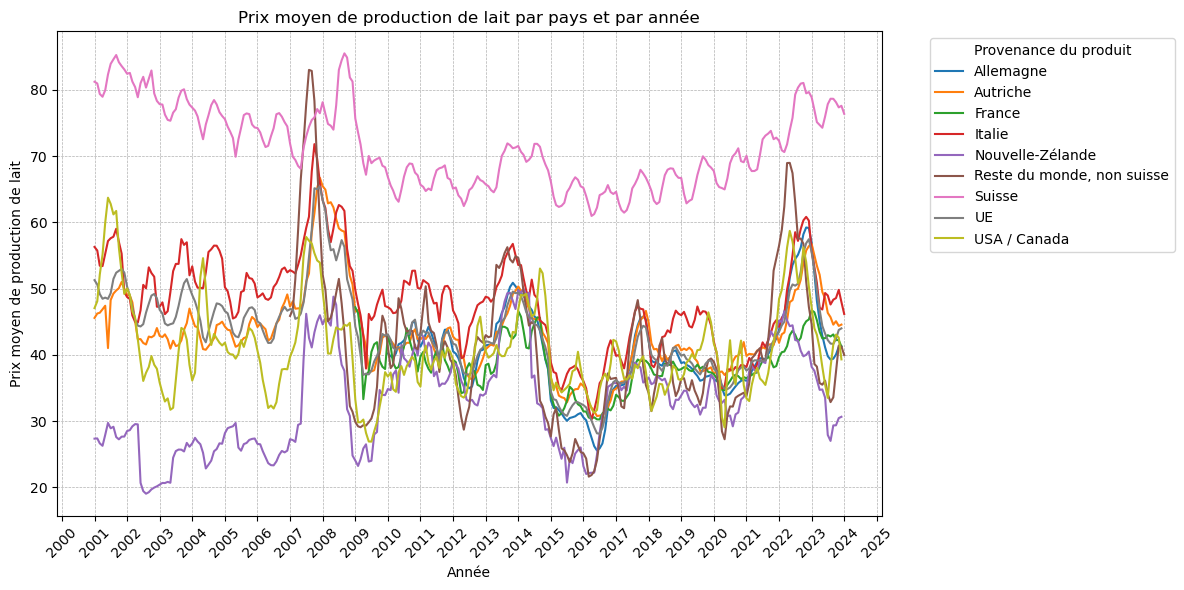

In [69]:
# Convert date from string to datetime
clean_data['Date'] = pd.to_datetime(clean_data['Date'])

# Grouper les régions suisses ensemble 
suisse_region = ['Région 1', 'Région 2', 'Région 3', 'Région 4', 'Région 5', 'Other'] 

# Remplacer les noms des pays par 'Groupe'
clean_data['Provenance du produit'] = clean_data['Provenance du produit'].replace(suisse_region, 'Suisse')


# Grouper les données par 'Provenance du produit' et 'Date', puis calculer la moyenne des prix 
prix_moyen_par_pays_et_annee = clean_data.groupby(['Provenance du produit', 'Date'])['Prix'].mean().reset_index()

# Préparer la figure
plt.figure(figsize=(12, 6))

# Boucler sur chaque pays pour le tracer
for pays in prix_moyen_par_pays_et_annee['Provenance du produit'].unique():
    subset = prix_moyen_par_pays_et_annee[prix_moyen_par_pays_et_annee['Provenance du produit'] == pays]
    plt.plot(subset['Date'], subset['Prix'], label=pays)

# Ajouter des légendes et titres
plt.legend()
plt.title('Prix moyen de production de lait par pays et par année')
plt.xlabel('Année')
plt.ylabel('Prix moyen de production de lait')
plt.legend(title='Provenance du produit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45) # Pour une meilleure lisibilité des dates
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Utilisation des locators et formatters pour l'axe des x
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Un tick par année
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Afficher seulement l'année

plt.tight_layout()  # Ajuste la disposition
plt.show()



coucou 